[https://twitter.com/bubblbu_/status/1068007871105748993](https://twitter.com/bubblbu_/status/1068007871105748993)

# Making Knowledge Public - Annotations & Engagement
> Asura Enkhbayar - 29.11.2018

In [1]:
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
from statistics import median, mean

import matplotlib.dates as mdates
import numpy as np
import json

In [138]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)

URL_PATTERN = "((http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?)"

def rand_jitter(arr):
    return arr + np.random.randn(len(arr)) * .05

## The Data

### 1. Making Knowledge Public - Course Material

Data retrieved from course page

In [222]:
classes = pd.read_json("../data/classes.json", orient="records").T
classes.date = classes.date.map(lambda x: x + "T17:30")
classes.date = pd.to_datetime(classes.date, format="%d/%m/%YT%H:%M")
usernames = json.load(open("../data/usernames.json"))

readings = pd.read_csv("../data/readings.csv", index_col="id", parse_dates=['date'])

readings.sample(10)

,url,week,part,date,required,speaker,total,resp
id,,,,,,,,
19,https://thewinnower.com/papers/4715-correlatin...,9,3,2018-11-01,True,Juan Pablo Alperin,37,"[{""permissions"": {""read"": [""group:__world__""],..."
3,http://www.inf.fu-berlin.de/lehre/pmo/eng/Saga...,2,0,2018-09-13,True,Jevin West,72,"[{""permissions"": {""read"": [""group:__world__""],..."
7,https://www.scholcommlab.ca/wp-content/uploads...,3,1,2018-09-20,True,Nancy Olewiler,43,"[{""permissions"": {""read"": [""group:__world__""],..."
21,https://peerj.com/articles/4375/,9,3,2018-11-01,True,Juan Pablo Alperin,40,"[{""permissions"": {""read"": [""group:__world__""],..."
35,https://generousthinking.hcommons.org/5-the-un...,12,3,2018-11-22,True,Robin DeRosa,4,"[{""permissions"": {""read"": [""group:__world__""],..."
31,https://generousthinking.hcommons.org/4-workin...,12,3,2018-11-22,True,Robin DeRosa,10,"[{""permissions"": {""read"": [""group:__world__""],..."
2,http://www2.csudh.edu/ccauthen/576f12/frankfur...,2,0,2018-09-13,True,Jevin West,105,"[{""permissions"": {""read"": [""group:__world__""],..."
27,http://robinderosa.net/uncategorized/open-for-...,12,3,2018-11-22,True,Robin DeRosa,29,"[{""permissions"": {""read"": [""group:__world__""],..."
36,https://generousthinking.hcommons.org/5-the-un...,12,3,2018-11-22,True,Robin DeRosa,9,"[{""permissions"": {""read"": [""group:__world__""],..."


### 2. Survey among students

Survey created with Google Forms

In [224]:
survey = pd.read_csv("../data/survey.csv")
eng_survey = survey[['What is your Hypothesis username?', 'eng_part', 'eng_week', 'eng_reading']]
eng_survey.columns = ['user', 'eng_part', 'eng_week', 'eng_reading']
eng_survey = eng_survey.set_index("user")

eng_survey.head()

,eng_part,eng_week,eng_reading
user,,,
anastasiak,1,5,3.0
cypriine,2,12,23.0
carina.albrecht,2,5,20.0
michelle_la,3,12,22.0
CSG,3,10,28.0


## 3. Our Annotations

Data retrieved for the individual readings from the Hypothesis API

In [225]:
comments = pd.read_csv("../data/comments.csv", index_col="id", parse_dates=['created', 'updated'])
comments = comments.merge(readings[['url', 'week', 'part', 'date', 'required', 'speaker']], left_on="url_id", right_index=True)

# Combine the last weeks annotations that were spread across several links
merge_urls = list(range(28, 38))

resps = []
for i in merge_urls:
    resps.extend(json.loads(readings.loc[i, "resp"]))
readings.loc[28, 'resp'] = json.dumps(resps)
readings.loc[28, 'total'] = len(resps)
readings.drop(merge_urls[1:], inplace=True)

comments.url_id = comments.url_id.map(lambda x: 28 if x in merge_urls else x)
our_comments = comments[comments.user.isin(usernames)]

our_comments.head()

,url_id,user,text,created,updated,references,in_class,url,week,part,date,required,speaker
id,,,,,,,,,,,,,
x_FSCrvLEeioqHu7TwVYAw,1,KariGustafson,So publishers were digging their own graves. O...,2018-09-19 05:20:54.141484,2018-09-19 05:20:54.141484,NaN,True,https://repository.arizona.edu/bitstream/handl...,1,0,2018-09-06,True,Juan Pablo Alperin
_9tGzLvKEeib-_-vb2H6Tg,1,KariGustafson,"Not only greater understanding of the world, b...",2018-09-19 05:15:18.449999,2018-09-19 05:15:18.449999,NaN,True,https://repository.arizona.edu/bitstream/handl...,1,0,2018-09-06,True,Juan Pablo Alperin
0AeaDrvKEeib-ofcsKitig,1,KariGustafson,This is a interesting thought - and leads in s...,2018-09-19 05:13:58.211944,2018-09-19 05:13:58.211944,NaN,True,https://repository.arizona.edu/bitstream/handl...,1,0,2018-09-06,True,Juan Pablo Alperin
sDYHcLgsEeiFGb8WQeG8HA,2,Bubblbu,my favourite kind of analysis!,2018-09-14 14:44:30.830468,2018-09-14 14:44:30.830468,NaN,True,http://www2.csudh.edu/ccauthen/576f12/frankfur...,2,0,2018-09-13,True,Jevin West
NP7LLrefEeimMQP4R0Wucg,2,cypriine,"I have to assume that we have to, because main...",2018-09-13 21:51:45.107694,2018-09-13 21:51:45.107694,['td258rZREeiLlldMrYu7rw'],True,http://www2.csudh.edu/ccauthen/576f12/frankfur...,2,0,2018-09-13,True,Jevin West


## A (terrible) overview

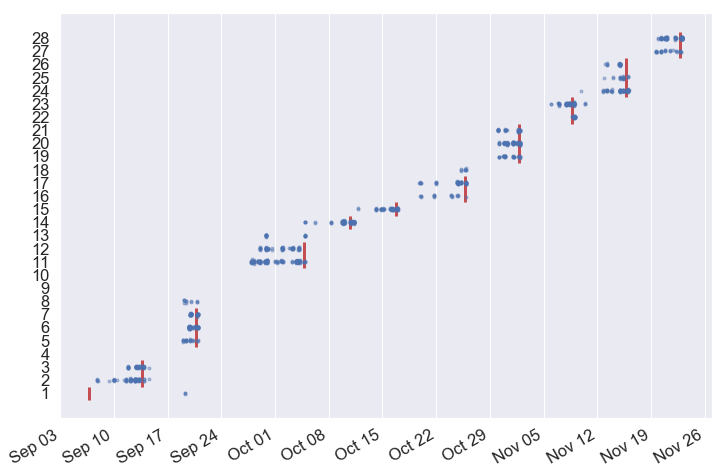

In [232]:
pdf = our_comments[our_comments.in_class == True]
fig, ax = plt.subplots()

# sns.pointplot(x="created", y="url_id", hue="in_class", data=pdf, ci=None, join=False, ax=ax, marker=".")
ax.plot(pdf.created, rand_jitter(pdf.url_id), marker=".", ls='', alpha=.4)

ax.yaxis.set_ticks(range(1,29))
start, end = ax.get_ylim()

for w, urls in weeks.items():
    wmin = min(urls)
    wmax = max(urls)
    date = classes.loc[w, 'date']
    ax.vlines(date, wmin-.5, wmax+.5, colors="r", lw=3, alpha=1)
    
mondays = mdates.WeekdayLocator(mdates.MONDAY)
ax.xaxis.set_major_locator(mondays)

weekFormatter = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(weekFormatter)

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
fig.autofmt_xdate()

ax.yaxis.grid(False)

## Number of comments as a measure of engagement

In [157]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])

x = our_comments.groupby(["user", "part"])['text'].count().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x['text'].idxmax()])['part']

x = our_comments.groupby(["user", "week"])['text'].count().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x['text'].idxmax()])['week']

x = our_comments.groupby(["user", "url_id"])['text'].count().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x['text'].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df

,part,survey_part,week,survey_week,reading,survey_reading
user,,,,,,
Bubblbu,3,NaN,11,NaN,24,NaN
CSG,2,3.0,5,10.0,11,28.0
KariGustafson,2,NaN,5,NaN,11,NaN
aliceLF,2,0.0,5,3.0,11,2.0
anastasiak,2,1.0,5,5.0,14,3.0
camilleweinsheimer,3,2.0,2,8.0,2,27.0
carina.albrecht,2,2.0,5,5.0,12,20.0
cypriine,3,2.0,6,12.0,14,23.0
juan,2,NaN,5,NaN,11,NaN


In [248]:
cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    matches[c] = df[c] == df["survey_" + c]
matches

,part,week,reading
user,,,
Bubblbu,False,False,False
CSG,False,False,False
KariGustafson,False,False,False
aliceLF,False,False,False
anastasiak,False,True,False
camilleweinsheimer,False,False,False
carina.albrecht,True,True,False
cypriine,False,False,False
juan,False,False,False


In [249]:
matches.sum()

part       3
week       2
reading    0
dtype: int64

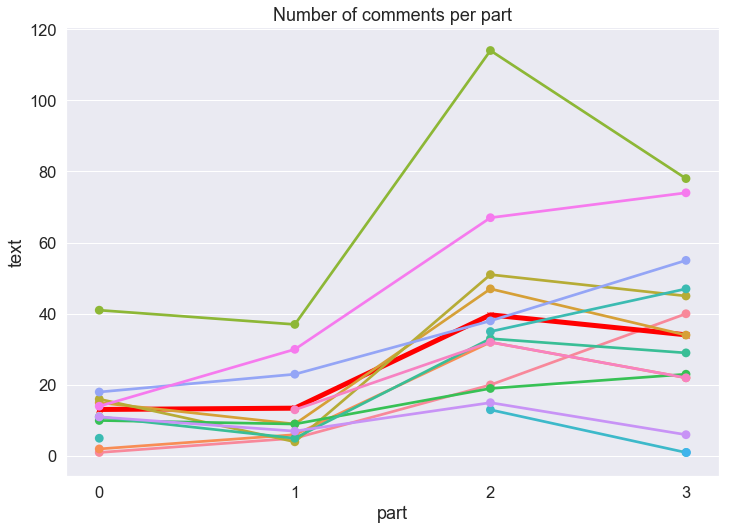

In [192]:
pdf = our_comments.groupby(["user", "part"])['text'].count().reset_index()
sns.pointplot(x="part", y="text", hue="user", data=pdf)

x = pdf.groupby(["part"]).mean()
plt.plot(x, c="red", lw="5", marker="x")

plt.gca().legend_.remove()
plt.title("Number of comments per part");

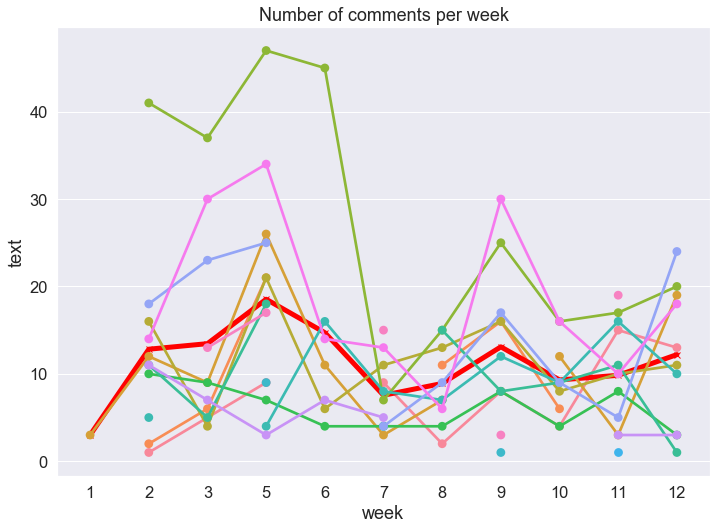

In [208]:
pdf = our_comments.groupby(["user", "week"])['text'].count().reset_index()
sns.pointplot(x="week", y="text", hue="user", data=pdf)

x = pdf.groupby(["week"]).mean()
plt.plot(x.text.values, c="red", lw="5", marker="x")

plt.gca().legend_.remove()
plt.title("Number of comments per week");

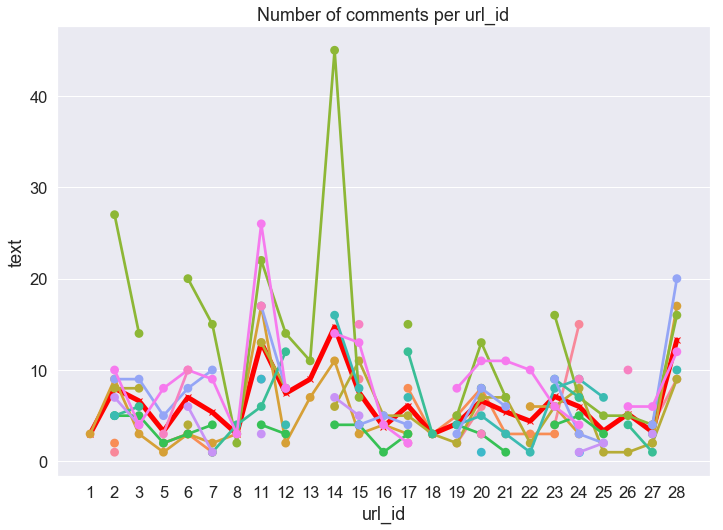

In [210]:
pdf = our_comments.groupby(["user", "url_id"])['text'].count().reset_index()
sns.pointplot(x="url_id", y="text", hue="user", data=pdf)

x = pdf.groupby(["url_id"]).mean()
plt.plot(x.text.values, c="red", lw="5", marker="x")

plt.gca().legend_.remove()
plt.title("Number of comments per url_id");

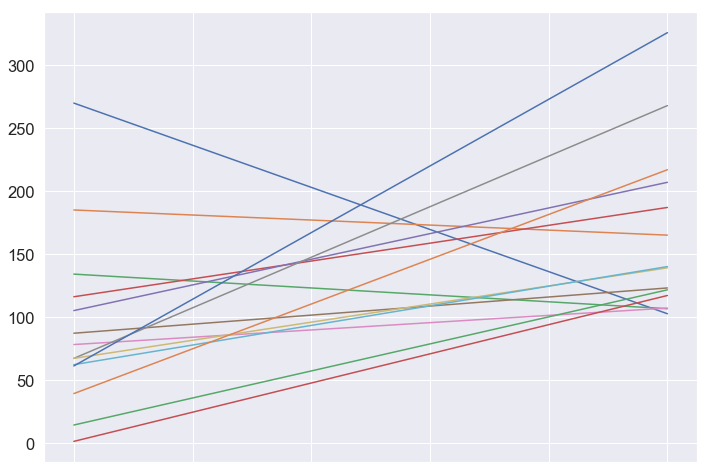

In [218]:
counts = pd.DataFrame(columns=["total", "median", "mean"])
counts['total'] = our_comments.user.value_counts()
counts['median'] = our_comments.groupby("user")["text"].apply(lambda x: median([len(str(y)) for y in x.tolist()]))
counts.T.plot(legend=False)

## Reading Times

In [133]:
reading_times = pd.DataFrame(columns=["url_id", "week", "user", "mins", "comments"])

for user in usernames:
    for uid in comments.url_id.unique():
        c = comments[(comments.user==user)&(comments.url_id==uid)]
        count = len(c)
        if count > 1:
            reading_time = max(c.created)-min(c.updated)
            reading_time = int(reading_time.seconds // 60)
            reading_times.loc[len(reading_times)+1] = [uid, c.week.iloc[0], user, reading_time, count]
reading_times.mins = reading_times.mins.astype(int)
reading_times.comments = reading_times.comments.astype(int)

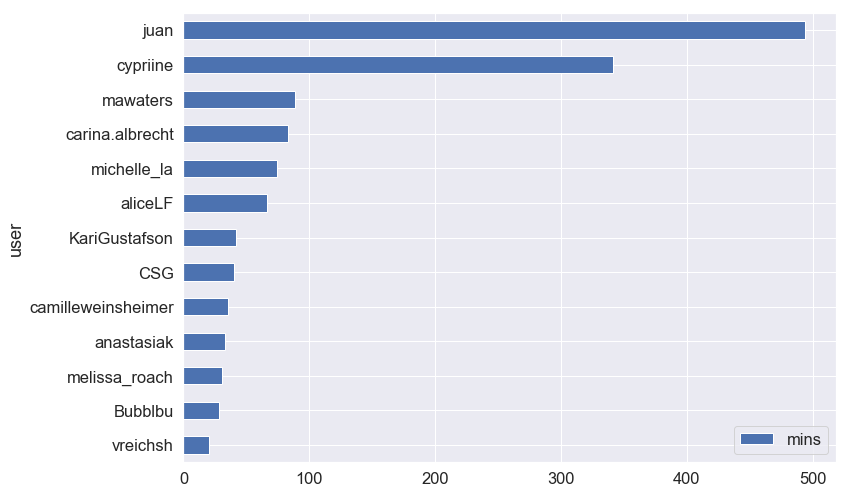

In [134]:
pd.DataFrame(reading_times.groupby("user")['mins'].median()).sort_values(by="mins").plot(kind="barh")

In [149]:
reading_times[~reading_times.user.isin(["juan", 'cypriine'])][['mins', 'comments']].corr(method="spearman")

,mins,comments
mins,1.000000,0.547926
comments,0.547926,1.000000


## Comments with URLs

What about annotations that link to other material?
Is that a particularly engaging activity?

In [214]:
our_comments['Has URL'] = our_comments.text.map(lambda x: re.search(URL_PATTERN, x) is not None if not pd.isna(x) else None)
pdf = our_comments.groupby("user")['Has URL'].apply(lambda x: sum([int(y) if not pd.isna(y) else 0 for y in x]))

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


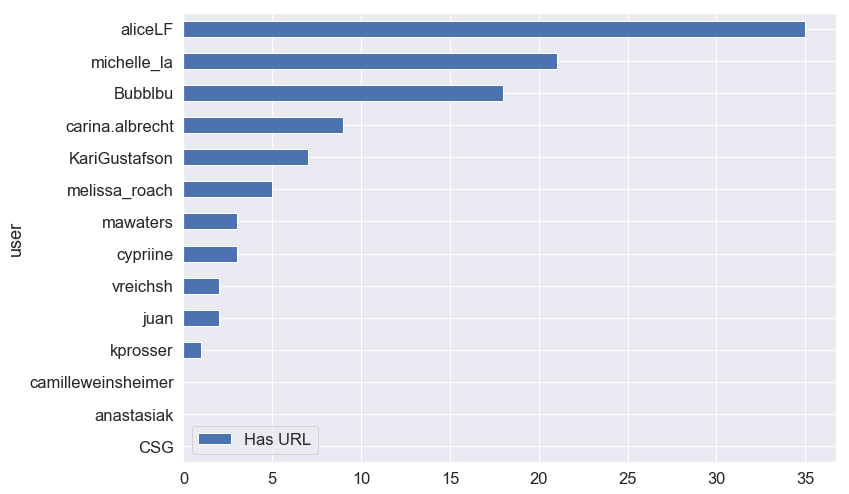

In [216]:
pd.DataFrame(pdf).sort_values(by="Has URL").plot(kind="barh")